<div style="width: 100%; clear: both;">
  <div style="float: left; width: 50%;">
    <img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
  </div>
  <div style="float: right; width: 50%;">
    <p style="padding-top: 42px; text-align:right;">&nbsp;</p>
    <p style="padding-top: 42px; text-align:right;">M2.882 - TFM - Area 5 aula 1</p>
    <p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (Data science)</p>
  </div>
   <div style="width:100%; clear: both;">&nbsp;</div>
</div>

# PEC3 - Design & implementation

## Sale of access IoT devices in underground forums

Autor: [Sergio Fernández García](mailto:serfer2@protonmail.com)

In [1]:
from datetime import date
from typing import List

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sn
from psycopg2 import connect
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    RocCurveDisplay,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

from application.services import HackForumsPostsCount
from infrastructure.repositories import (
    ForumDBRepository,
    PostsCountDBRepository,
)
from shared.constants import PAYMENT_METHODS

sn.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.0})
sn.set_palette("tab10")

def get_dbc():
    return connect(
        host='localhost',
        database='crimebb',
        user='crimebb',
        password='crimebbinlocalhost',
    )

### Data source

Given all threads from *Hack Forums* `Market` section, each document is a mix of data: Thread heading + First post content and timestamp.

All threads from sub-forums in Market section have been pre-processed. We've built two datasets by filtering all DDoS related threads:

- `ddos_full_dataset.csv`: (>40K docs) Full dataset with all market section documents related with DDoS.
- `ddos_groundtruth_dataset.csv`: (4K docs) Data sample, randomly extracted from full dataset. Every doc category has been annotated by differenciating beteen `supply` and `demand`. This dataset is intended for training and testing text classification models.

**NOTE:**

All contents have been cleaned when building the datasets. So we've clean words, ready to work with it.

Cleaning operations have been:

- Lower case all text.
- Removed: punctuation, accents, non-textual content like citing, images, urls, ... 

In [2]:
# Load both datasets

gtruth_df = pd.read_csv('datasets/ddos_ground_truth_dataset.csv')

gtruth_df.info()
gtruth_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4071 entries, 0 to 4070
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   site            4071 non-null   int64 
 1   thread          4071 non-null   int64 
 2   post            4071 non-null   int64 
 3   content         4071 non-null   object
 4   tstamp          4071 non-null   object
 5   matching_terms  4071 non-null   object
 6   category        4071 non-null   object
dtypes: int64(3), object(4)
memory usage: 222.8+ KB


,site,thread,post,content,tstamp,matching_terms,category
0,0,16115,93673,selling botnet zombies i'm selling a botnet 15...,2008-05-03 12:51:00+00:00,['botnet'],supply
1,0,67711,593690,i want to buy a botnet i am paying 0 20$ for e...,2009-04-16 02:19:00+00:00,['botnet'],demand
2,0,68382,600494,i want to buy a botnet i want to buy a botnet ...,2009-04-18 01:48:00+00:00,['botnet'],demand
3,0,81356,725485,selling fud copies of bandook rat 6 months upd...,2009-05-27 09:35:00+00:00,['ddos'],supply
4,0,82357,735031,selling up to 300 bots $0 50 each hello i am s...,2009-05-30 05:07:00+00:00,['botnet'],supply


In [3]:
# Categories as numeric values

categories = {v: i for i, v in enumerate(set(gtruth_df['category'].values))}
print(f'{categories}')
labels = [l for l in categories.values()]
target_names = [n for n in categories.keys()]

gtruth_df['target'] = [categories[c] for c in gtruth_df['category']]
gtruth_df.head()

{'supply': 0, 'demand': 1}


,site,thread,post,content,tstamp,matching_terms,category,target
0,0,16115,93673,selling botnet zombies i'm selling a botnet 15...,2008-05-03 12:51:00+00:00,['botnet'],supply,0
1,0,67711,593690,i want to buy a botnet i am paying 0 20$ for e...,2009-04-16 02:19:00+00:00,['botnet'],demand,1
2,0,68382,600494,i want to buy a botnet i want to buy a botnet ...,2009-04-18 01:48:00+00:00,['botnet'],demand,1
3,0,81356,725485,selling fud copies of bandook rat 6 months upd...,2009-05-27 09:35:00+00:00,['ddos'],supply,0
4,0,82357,735031,selling up to 300 bots $0 50 each hello i am s...,2009-05-30 05:07:00+00:00,['botnet'],supply,0


In [4]:
# Split ground truth dataset for training and test (80/20 ratio)

gtruth_training_df = gtruth_df.sample(frac=0.8)
gtruth_testing_df = gtruth_df.drop(gtruth_training_df.index)

print(f'{gtruth_training_df.shape}')
print(f'{gtruth_testing_df.shape}')

(3257, 8)
(814, 8)


### Data pre-process

Since there are a lot of different words in corpus, we've a high dimensional dataset (too much different features).

Building feature vectors with full word list is inefficient and can be unmanageable. This is why we're going to maintain in memory only non-zero parts of feature vectors.

#### Tokenization:

Before building feature vectors, tokenization is needed. It basically consists in breaking down text in term vectors and filtering *stop words*.

In [5]:
X_train_counts = CountVectorizer().fit_transform(gtruth_training_df['content'])
print(f'{X_train_counts.shape}')

(3257, 12586)


#### Term Frequency

Some thread contents are longer than others, it can result in a higher average count values than shorter ones, but they really talk about same topic (category).

Among that, some words appears in many documents in the corpus. These *common* words are less informative, so we'll downscale weights for these words.

In order to avoid this problem, we calculate *tf* and *tf-idf* (Term Frequency times Inverse Document Frequency). Both (*tf* and *tf-idf*) are computed by `TfidfTransformer`.

In [6]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(f'{X_train_tfidf.shape}')

(3257, 12586)


### Model training

We're going to test classification performance for four well-known models. These models are widely used in classification tasks:

- LinearSVC: Linear Support Vector Classification.
- SGD: Stochastic Gradient Descent.
- K nearest Neighbor.
- Multinomial Naive Bayes.

Performance metrics to be analyzed are *precision*, *recall*, *F1-score* and occurrences of each class (*support*).

Confusion matrix will show us ratio of correct and wrong classification between categories (only two categories in our case).


In [7]:
def evaluate_model(model_name, x_test, y_test, classifier, labels, target_names):
    # Prediction with test dataset
    predicted = classifier.predict(x_test)

    # Accuracy
    accuracy = accuracy_score(y_true=gtruth_testing_df['target'], y_pred=predicted)
    print(f'{model_name} accuracy: {accuracy:.02f}')

    # Metrics
    metrics = classification_report(
        y_true=y_test,
        y_pred=predicted,
        labels=labels,
        target_names=target_names,
        output_dict=True,
    )

    # Confusion matrix
    cfm = pd.crosstab(
        y_test,
        predicted,
        rownames=['Category'],
        colnames=['Pred. category'],
    )

    return predicted, metrics, cfm


def plot_confusion_matrix(cfm, title):
    _, ax = plt.subplots(1, 1, figsize=(4, 3))
    sn.heatmap(cfm, annot=True, cmap='Blues', fmt='d', ax=ax)
    ax.set_title(f'{title} - Confusion Matrix')
    plt.show()

#### LinearSVC

LinearSVC accuracy: 0.96


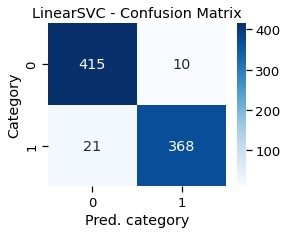

In [8]:
linear_svc_text_classifier = Pipeline(
    steps=[
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', LinearSVC(random_state=0, tol=1e-05)),
    ]
)

# Training

linear_svc_text_classifier.fit(
    X=gtruth_training_df['content'],
    y=gtruth_training_df['target'],
)

# Prediction & model evaluation

linear_svc_predicted, _linear_svc_metrics, linear_svc_cfm = evaluate_model(
    model_name='LinearSVC',
    x_test=gtruth_testing_df['content'],
    y_test=gtruth_testing_df['target'],
    classifier=linear_svc_text_classifier,
    labels=labels,
    target_names=target_names,
)
linear_svc_metrics = _linear_svc_metrics.get('macro avg')
linear_svc_metrics['accuracy'] = _linear_svc_metrics.get('accuracy')

plot_confusion_matrix(cfm=linear_svc_cfm, title='LinearSVC')

#### Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) accuracy: 0.93


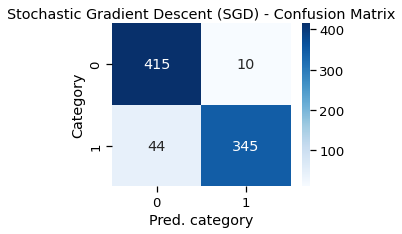

In [9]:
sgd_model = SGDClassifier(
    loss='hinge',
    penalty='l2',
    alpha=1e-3,
    random_state=42,
    max_iter=5,
    tol=None,
)
sgd_text_classifier = Pipeline(
    steps=[
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', sgd_model),
    ]
)

# Training

sgd_text_classifier.fit(
    X=gtruth_training_df['content'],
    y=gtruth_training_df['target'],
)

# Prediction & model evaluation

sgd_predicted, _sgd_metrics, sgd_cfm = evaluate_model(
    model_name='Stochastic Gradient Descent (SGD)',
    x_test=gtruth_testing_df['content'],
    y_test=gtruth_testing_df['target'],
    classifier=sgd_text_classifier,
    labels=labels,
    target_names=target_names,
)
sgd_metrics = _sgd_metrics.get('macro avg')
sgd_metrics['accuracy'] = _sgd_metrics.get('accuracy')

plot_confusion_matrix(cfm=sgd_cfm, title='Stochastic Gradient Descent (SGD)')

#### K-nearest neighbors

K-nearest neighbors accuracy: 0.80


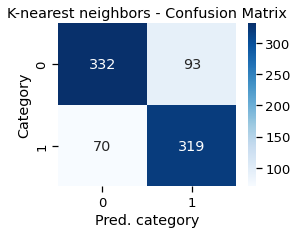

In [10]:
knn_text_classifier = Pipeline(
    steps=[
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', KNeighborsClassifier(n_neighbors=12)),
    ]
)

# Training

knn_text_classifier.fit(
    X=gtruth_training_df['content'],
    y=gtruth_training_df['target'],
)

# Prediction & model evaluation

knn_predicted, _knn_metrics, knn_cfm = evaluate_model(
    model_name='K-nearest neighbors',
    x_test=gtruth_testing_df['content'],
    y_test=gtruth_testing_df['target'],
    classifier=knn_text_classifier,
    labels=labels,
    target_names=target_names,
)
knn_metrics = _knn_metrics.get('macro avg')
knn_metrics['accuracy'] = _knn_metrics.get('accuracy')

plot_confusion_matrix(cfm=knn_cfm, title='K-nearest neighbors')

#### Multinomial Naïve Bayes

Multinomial Naïve Bayes accuracy: 0.89


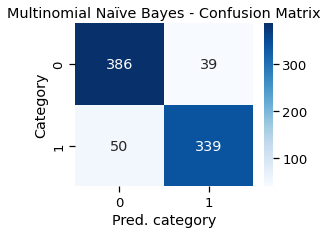

In [11]:
mnb_text_classifier = Pipeline(
    steps=[
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('classifier', MultinomialNB()),
    ]
)

# Training

mnb_text_classifier.fit(
    X=gtruth_training_df['content'],
    y=gtruth_training_df['target'],
)

# Prediction & model evaluation

mnb_predicted, _mnb_metrics, mnb_cfm = evaluate_model(
    model_name='Multinomial Naïve Bayes',
    x_test=gtruth_testing_df['content'],
    y_test=gtruth_testing_df['target'],
    classifier=mnb_text_classifier,
    labels=labels,
    target_names=target_names,
)
mnb_metrics = _mnb_metrics.get('macro avg')
mnb_metrics['accuracy'] = _mnb_metrics.get('accuracy')

plot_confusion_matrix(cfm=mnb_cfm, title='Multinomial Naïve Bayes')

### Model evaluation

In [12]:
models_report = pd.DataFrame({
    'model': ['Linear Support Vector Classification.', 'Stochastic Gradient Descent', 'K-nearest Neighbor', 'Multinomial Naïve Bayes'],
    'accuracy': [linear_svc_metrics['accuracy'], sgd_metrics['accuracy'], knn_metrics['accuracy'], mnb_metrics['accuracy'],],
    'precision': [linear_svc_metrics['precision'], sgd_metrics['precision'], knn_metrics['precision'], mnb_metrics['precision'],],
    'recall': [linear_svc_metrics['recall'], sgd_metrics['recall'], knn_metrics['recall'], mnb_metrics['recall'],],
    'F1 score': [linear_svc_metrics['f1-score'], sgd_metrics['f1-score'], knn_metrics['f1-score'], mnb_metrics['f1-score'],],
}).sort_values(
    by='accuracy',
    ascending=False
)

#### Metrics

In [13]:
models_report

,model,accuracy,precision,recall,F1 score
0,Linear Support Vector Classification.,0.961916,0.962690,0.961243,0.961789
1,Stochastic Gradient Descent,0.933661,0.937985,0.931680,0.933167
3,Multinomial Naïve Bayes,0.890663,0.891073,0.889850,0.890298
2,K-nearest Neighbor,0.799754,0.800071,0.800614,0.799703


#### ROC curve

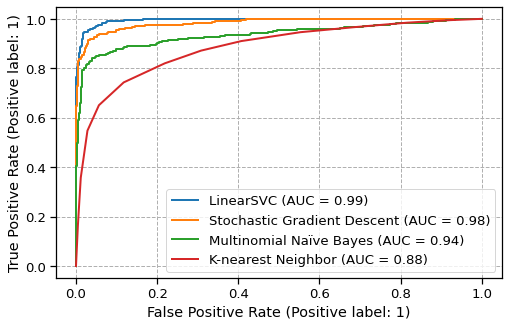

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
RocCurveDisplay.from_estimator(linear_svc_text_classifier, gtruth_testing_df['content'], gtruth_testing_df['target'], ax=ax, name='LinearSVC')
RocCurveDisplay.from_estimator(sgd_text_classifier, gtruth_testing_df['content'], gtruth_testing_df['target'], ax=ax, name='Stochastic Gradient Descent')
RocCurveDisplay.from_estimator(mnb_text_classifier, gtruth_testing_df['content'], gtruth_testing_df['target'], ax=ax, name='Multinomial Naïve Bayes')
RocCurveDisplay.from_estimator(knn_text_classifier, gtruth_testing_df['content'], gtruth_testing_df['target'], ax=ax, name='K-nearest Neighbor')
ax.grid(linestyle="--")
plt.show()

#### Model Selection

According to evaluation results, best performing model is **LinearSVC** (*Linear Support Vector Classifier*).

### Data Analysis

Once we've selected a model, it's time to analyse full dataset.

First, we need to load full dataset and label docs according to model predictions.

In [15]:
# Load full dataset

full_df = pd.read_csv('datasets/ddos_full_dataset.csv')
full_df.head()

# Label documents by using selected model predictions

categories_by_value = {v: k for k, v in categories.items()}  # {'demand': 0, 'supply': 1} -> {0: 'demand', 1: 'supply'}
labeled_full_df = full_df.copy()
labeled_full_df['category'] = linear_svc_text_classifier.predict(full_df['content'])
labeled_full_df['category_name'] = [categories_by_value[value] for value in labeled_full_df['category']]
labeled_full_df.head()

,site,thread,post,content,tstamp,matching_terms,category,category_name
0,0,11481,53361,buying botnet im buying a good botnet with alo...,2008-02-18 08:37:00+00:00,['botnet'],1,demand
1,0,12919,61516,botnet with undetected server 4sale hey people...,2008-03-21 08:47:00+00:00,['botnet'],0,supply
2,0,13901,70758,interested in purchasing a botnet im intereste...,2008-04-09 04:41:00+00:00,"['botnet', 'ddos']",1,demand
3,0,14432,77296,trojans botnet source keyloggers packers crypt...,2008-04-15 07:57:00+00:00,['botnet'],0,supply
4,0,15291,85997,professional bulletproof hosting service from ...,2008-04-24 12:11:00+00:00,['botnet'],0,supply


#### Supply vs Demand

Our purpose here is to analyse supply and demand evolution over time.

Then we'll extract relevant information as frequent tech terms, contact methods, preferred payment methods and so on.

In [16]:
# Auxiliar functions, just to avoid dupplicated code

def add_date_column(df):
    """ Adds, in place, a 'date' column to a posts count dataframe"""
    df['date'] = [date(int(row.year), int(row.month), 1) for _, row in df.iterrows()]


def add_posts_ratio_colum(df, total_posts_by_date):
    """ 
        Adds, in place, a new column 'posts_ratio' with the ratio
        of posts by date according to the total of posts for that date
    """
    posts_ratio = []
    for _, row in df.iterrows():
        total_posts = total_posts_by_date.get(row['date'])
        ratio = 0.0
        if total_posts:
            ratio = row['posts'] / total_posts
        posts_ratio.append(ratio)
    df['posts_ratio'] = posts_ratio


def get_posts_by_date(df):
    return {row['date']: row['posts'] for _, row in df.iterrows()}


# Market section posts count over time

market_posts_count_df = pd.read_csv('datasets/market_section_posts_count_dataset.csv')
add_date_column(df=market_posts_count_df)

# DDoS related threads posts count over time

ddos_related_posts_count_df = pd.read_csv('datasets/ddos_posts_count_dataset.csv')
add_date_column(df=ddos_related_posts_count_df)
ddos_related_posts_by_date = get_posts_by_date(df=ddos_related_posts_count_df)

In [17]:
dbc = get_dbc()
posts_counter_service = HackForumsPostsCount(
    forum_repository=ForumDBRepository(dbc=dbc),
    posts_count_repository=PostsCountDBRepository(dbc=dbc),
)

# Count "supply" posts by month and year

supply_df = labeled_full_df.query('category_name == "supply"')
supply_thread_ids = list(set(supply_df['thread']))
supply_thread_ids.sort()
supply_thread_posts_count = posts_counter_service.count_threads_posts(thread_ids=supply_thread_ids)
supply_thread_posts_count_df = pd.DataFrame(supply_thread_posts_count)
add_date_column(df=supply_thread_posts_count_df)

# Count "demand" posts by month and year

demand_df = labeled_full_df.query('category_name == "demand"')
demand_thread_ids = list(set(demand_df['thread']))
demand_thread_ids.sort()
demand_thread_posts_count = posts_counter_service.count_threads_posts(thread_ids=demand_thread_ids)
demand_thread_posts_count_df = pd.DataFrame(demand_thread_posts_count)
add_date_column(df=demand_thread_posts_count_df)

dbc.close()

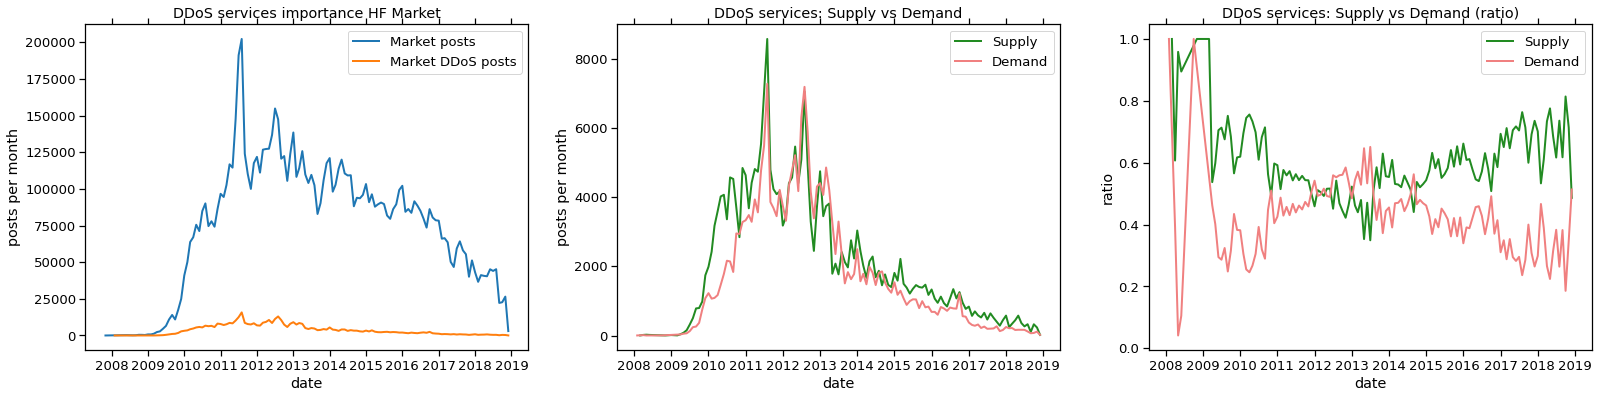

In [18]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(27, 6))

sn.lineplot(data=market_posts_count_df, x='date', y='posts', ax=ax1, label='Market posts')
sn.lineplot(data=ddos_related_posts_count_df, x='date', y='posts', ax=ax1, label='Market DDoS posts')
ax1.set_title('DDoS services importance HF Market')
ax1.xaxis.set_tick_params(reset=True)
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set(ylabel='posts per month')

sn.color_palette("Set2")
sn.lineplot(data=supply_thread_posts_count_df, x='date', y='posts', ax=ax2, label='Supply', color='forestgreen')
sn.lineplot(data=demand_thread_posts_count_df, x='date', y='posts', ax=ax2, label='Demand', color='lightcoral')
ax2.set_title('DDoS services: Supply vs Demand')
ax2.xaxis.set_tick_params(reset=True)
ax2.xaxis.set_major_locator(mdates.YearLocator(1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set(ylabel='posts per month')

# overall supply and demand ratio by month and year

add_posts_ratio_colum(df=supply_thread_posts_count_df, total_posts_by_date=ddos_related_posts_by_date)
sn.lineplot(data=supply_thread_posts_count_df, x='date', y='posts_ratio', ax=ax3, label='Supply', color='forestgreen')
add_posts_ratio_colum(df=demand_thread_posts_count_df, total_posts_by_date=ddos_related_posts_by_date)
sn.lineplot(data=demand_thread_posts_count_df, x='date', y='posts_ratio', ax=ax3, label='Demand', color='lightcoral')
ax3.set_title('DDoS services: Supply vs Demand (ratio)')
ax3.xaxis.set_tick_params(reset=True)
ax3.xaxis.set_major_locator(mdates.YearLocator(1))
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax3.set(ylabel='ratio')

plt.show()

#### Relevant tech terms

It is common to reffer to *Sale of access IoT devices* services by using different tech terms like *booter*, *stresser*, *ddoser*, and so on.

The use of some terms or others, when referring to these services, varies depending on the technology used to develop them, the intended use or simply the slang of the moment.

Let's see how the use of terms has evolved when referring to this type of service. 

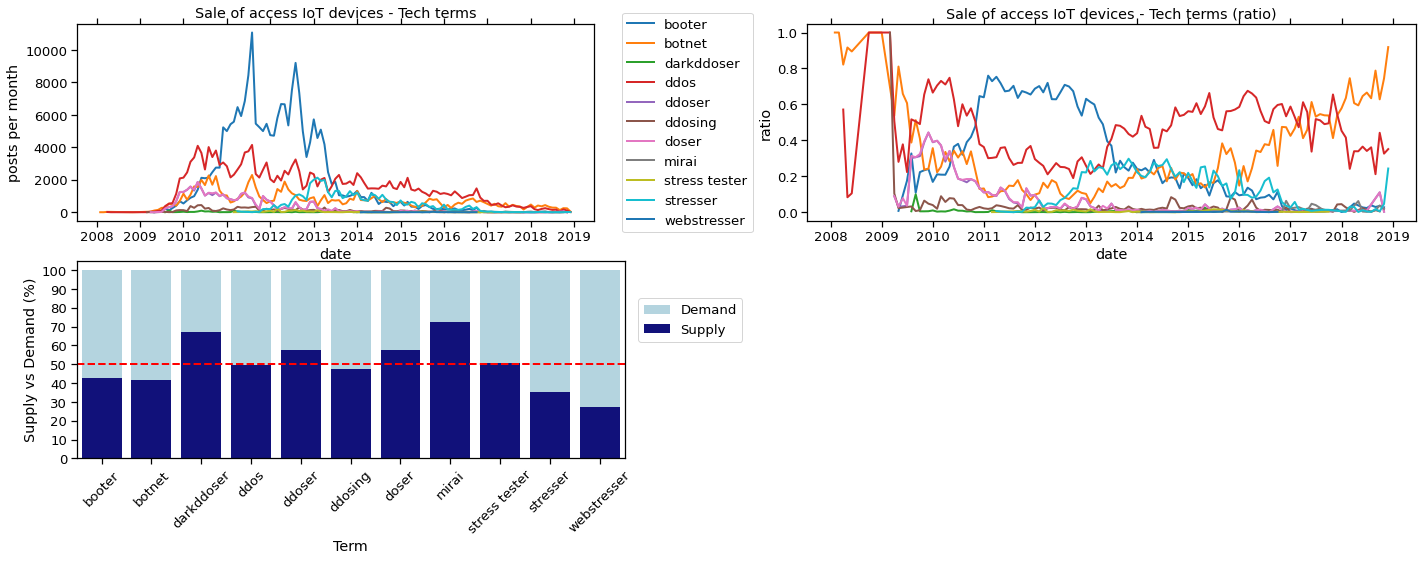

In [19]:
dbc = get_dbc()
posts_counter_service = HackForumsPostsCount(
    forum_repository=ForumDBRepository(dbc=dbc),
    posts_count_repository=PostsCountDBRepository(dbc=dbc),
)

# tech terms are stored in "matching terms" labeled_full_df column and have been identified during data extraction process.

labeled_full_df['tech_terms'] = labeled_full_df['matching_terms'].apply(eval)

tech_terms = list()
for _terms in labeled_full_df['tech_terms']:
    tech_terms += _terms
tech_terms = list(set(tech_terms))
tech_terms.sort()

fig, axes = plt.subplots(2, 2, figsize=(24, 8))
ax1, ax2, ax3, ax4 = axes.ravel()

supply_pcnt = []

# Prepare terms evolution data

for _term in tech_terms:
    _term_df = labeled_full_df.loc[labeled_full_df.apply(lambda x: _term in x.tech_terms, axis=1)]
    _term_supply_qty = _term_df.query('category_name == "supply"').shape[0]
    supply_pcnt.append(_term_supply_qty * 100 / _term_df.shape[0])

    _term_thread_ids = list(set(_term_df['thread']))
    _term_thread_ids.sort()
    _term_thread_posts_count = posts_counter_service.count_threads_posts(thread_ids=_term_thread_ids)
    _term_thread_posts_count_df = pd.DataFrame(_term_thread_posts_count)

    add_date_column(df=_term_thread_posts_count_df)
    g = sn.lineplot(data=_term_thread_posts_count_df, x='date', y='posts', ax=ax1, label=_term)

    add_posts_ratio_colum(df=_term_thread_posts_count_df, total_posts_by_date=ddos_related_posts_by_date)
    sn.lineplot(data=_term_thread_posts_count_df, x='date', y='posts_ratio', ax=ax2)

box = g.get_position()
g.set_position([box.x0, box.y0, box.width * 0.85, box.height])
g.legend(loc='center', bbox_to_anchor=(1.18, 0.5), ncol=1)

# Plot tech terms use as timeseries

ax1.set_title('Sale of access IoT devices - Tech terms')
ax1.xaxis.set_tick_params(reset=True)
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set(ylabel='posts per month')

# Plot tech terms ratio as timeseries

ax2.set_title('Sale of access IoT devices - Tech terms (ratio)')
ax2.xaxis.set_tick_params(reset=True)
ax2.xaxis.set_major_locator(mdates.YearLocator(1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set(ylabel='ratio')


terms_supply_demand_percent_df = pd.DataFrame({
    'Term': tech_terms,
    'Supply': supply_pcnt,
    'Demand': [100 for _ in range(len(tech_terms))],
})
sn.barplot(x="Term",  y="Demand", data=terms_supply_demand_percent_df, color='lightblue', ax=ax3, label='Demand')
g2 = supply_graph = sn.barplot(x="Term",  y="Supply", data=terms_supply_demand_percent_df, color='darkblue', ax=ax3, label='Supply')
supply_graph.set_xticklabels(tech_terms, rotation=45)
supply_graph.axhline(50, color='red', linestyle='--', linewidth=2)
supply_bar = mpatches.Patch(color='darkblue', label='supply')
demand_bar = mpatches.Patch(color='lightblue', label='demand')
ax3.set_yticks([i * 10 for i in range(11)])
ax3.set(ylabel='Supply vs Demand (%)')

box2 = g2.get_position()
g2.set_position([box2.x0, box2.y0, box2.width * 0.90, box2.height])
g2.legend(loc='center', bbox_to_anchor=(1.12, 0.7), ncol=1)

fig.delaxes(ax4)

dbc.close()

#### Preferred payment methods

Preferred payment methods used for the *Sale of access IoT devices* have evolved in last years.

Here we analise what payment methods have been used over time.

In [22]:
# Functions for filtering documents according to payment methods presence in content

def _has_payment_method(pmethod: str, content: str) -> bool:
    pmethod_data = PAYMENT_METHODS.get(pmethod)
    for expression in pmethod_data.get('expressions'):
        if expression in content:
            return True
    content_words = [word.strip() for word in content.split() if word.strip()]
    for word in pmethod_data.get('words'):
        if word in content_words:
            return True
    return False


def _has_any_payment_method(content: str) -> bool:
    for _pmethod in PAYMENT_METHODS:
        if _has_payment_method(_pmethod, content):
            return True
    return False

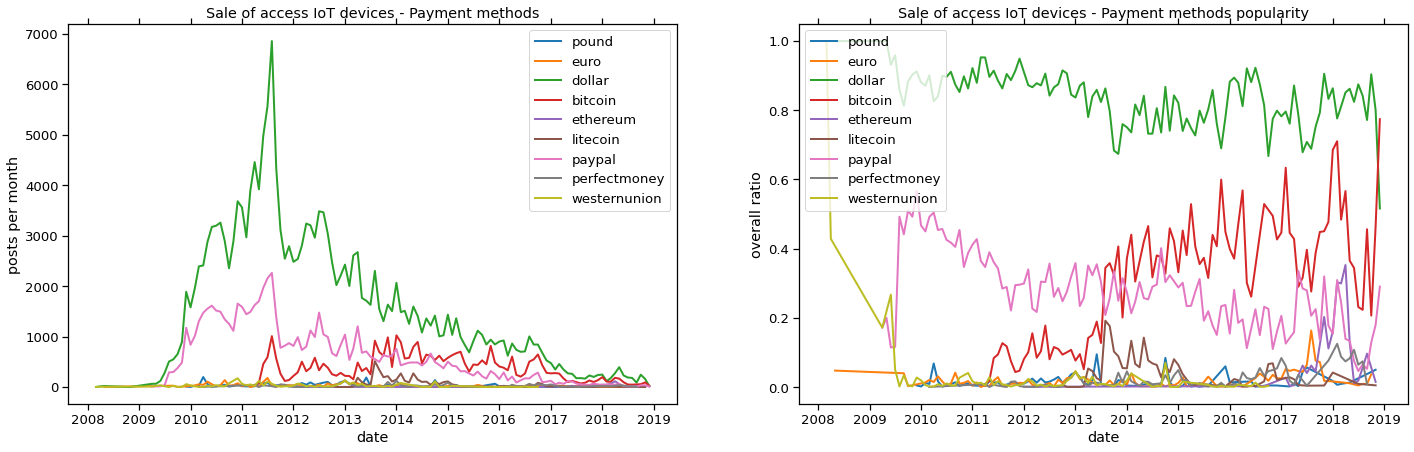

In [21]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(24, 7))

dbc = get_dbc()
posts_counter_service = HackForumsPostsCount(
    forum_repository=ForumDBRepository(dbc=dbc),
    posts_count_repository=PostsCountDBRepository(dbc=dbc),
)

full_with_payment_method_df = labeled_full_df.loc[labeled_full_df.apply(lambda x: _has_any_payment_method(x.content), axis=1)]
full_with_payment_method_thread_ids = list(set(full_with_payment_method_df['thread']))
full_with_payment_method_thread_ids.sort()
full_with_payment_method_posts_count = posts_counter_service.count_threads_posts(thread_ids=full_with_payment_method_thread_ids)
full_with_payment_method_posts_count_df = pd.DataFrame(full_with_payment_method_posts_count)

add_date_column(df=full_with_payment_method_posts_count_df)

full_with_payment_method_posts_by_date = get_posts_by_date(df=full_with_payment_method_posts_count_df)

for pmethod_name, pmethod_data in PAYMENT_METHODS.items():
    _pmethod_df = labeled_full_df.loc[labeled_full_df.apply(lambda x: _has_payment_method(pmethod_name, x.content), axis=1)]
    _pmethod_thread_ids = list(set(_pmethod_df['thread']))
    if not _pmethod_thread_ids:
        continue
    _pmethod_thread_ids.sort()
    _pmethod_thread_posts_count = posts_counter_service.count_threads_posts(thread_ids=_pmethod_thread_ids)
    _pmethod_thread_posts_count_df = pd.DataFrame(_pmethod_thread_posts_count)
    add_date_column(df=_pmethod_thread_posts_count_df)
    add_posts_ratio_colum(df=_pmethod_thread_posts_count_df, total_posts_by_date=full_with_payment_method_posts_by_date)
    g1 = sn.lineplot(data=_pmethod_thread_posts_count_df, x='date', y='posts', ax=ax1, label=pmethod_name)
    g2 = sn.lineplot(data=_pmethod_thread_posts_count_df, x='date', y='posts_ratio', ax=ax2, label=pmethod_name)

g2.legend(loc='upper right')
g2.legend(loc='upper left')

# Plot payment methods evolution as timeseries
ax1.set_title('Sale of access IoT devices - Payment methods')
ax1.xaxis.set_tick_params(reset=True)
ax1.xaxis.set_major_locator(mdates.YearLocator(1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.set(ylabel='posts per month')

# Plot payment methods popularity as timeseries (ratio)
ax2.set_title('Sale of access IoT devices - Payment methods popularity')
ax2.xaxis.set_tick_params(reset=True)
ax2.xaxis.set_major_locator(mdates.YearLocator(1))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.set(ylabel='overall ratio')

dbc.close()